In [544]:
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# for imputation
from pyod.models.knn  import KNN
import pyod

#model building
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

import gc
gc.collect()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [545]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.index = train.Loan_ID
train.drop(["Loan_ID"],axis=1,inplace = True)
train["Loan_Status"].replace({"Y":1,"N":0},inplace=True)

test.index = test.Loan_ID
test.drop(["Loan_ID"],axis=1,inplace = True)

In [546]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [547]:
test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [548]:
round(train.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.46,6109.04,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.25,2926.25,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.41,85.59,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.00,65.12,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.84,0.36,0.0,1.0,1.0,1.00,1.0
Loan_Status,614.0,0.69,0.46,0.0,0.0,1.0,1.00,1.0


In [549]:
round(test.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,367.0,4805.60,4910.69,0.0,2864.00,3786.0,5060.0,72529.0
CoapplicantIncome,367.0,1569.58,2334.23,0.0,0.00,1025.0,2430.5,24000.0
LoanAmount,362.0,136.13,61.37,28.0,100.25,125.0,158.0,550.0
Loan_Amount_Term,361.0,342.54,65.16,6.0,360.00,360.0,360.0,480.0
Credit_History,338.0,0.83,0.38,0.0,1.00,1.0,1.0,1.0


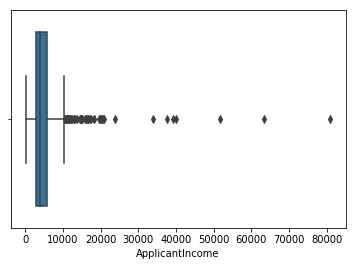

In [550]:
#to check the distributio  of income
# will use Inter Quantile range to later modify the outliers
sns.boxplot(x=train['ApplicantIncome'])

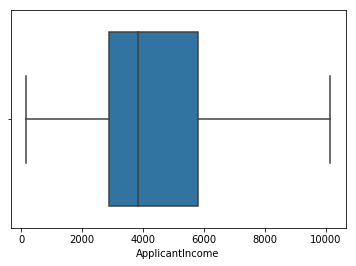

In [551]:
temp=train.copy()
q1 = temp["ApplicantIncome"].quantile(0.25)
q2 = temp["ApplicantIncome"].quantile(0.75)
iqr  = q2-q1
temp['ApplicantIncome'] = np.where(temp['ApplicantIncome']>(1.5*iqr+q2),q2,temp['ApplicantIncome'])
sns.boxplot(x=temp['ApplicantIncome'])

In [552]:
k = pd.DataFrame()
k["train"] = train.dtypes
k['test'] = test.dtypes
k.T

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
train,object,object,object,object,object,int64,float64,float64,float64,float64,object,int64
test,object,object,object,object,object,int64,int64,float64,float64,float64,object,NaN


In [553]:
k = pd.DataFrame()
k["train"] = round(100*train.isna().sum()/len(train),2)
k["test"] = round(100*test.isna().sum()/len(test),2)
k.T

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
train,2.12,0.49,2.44,0.0,5.21,0.0,0.0,3.58,2.28,8.14,0.0,0.0
test,3.00,0.00,2.72,0.0,6.27,0.0,0.0,1.36,1.63,7.90,0.0,NaN


In [554]:
cols =[col for col in train.columns if train[col].dtype=='object']
for col in cols:
    df = train.groupby([col,'Loan_Status']).size().unstack()
    df["approved_ratio"] =100*round(df[1]/df.sum(axis=1),2)
    print(df,end="\n\n\n")

Loan_Status    0    1  approved_ratio
Gender                               
Female        37   75            67.0
Male         150  339            69.0


Loan_Status    0    1  approved_ratio
Married                              
No            79  134            63.0
Yes          113  285            72.0


Loan_Status    0    1  approved_ratio
Dependents                           
0            107  238            69.0
1             36   66            65.0
2             25   76            75.0
3+            18   33            65.0


Loan_Status     0    1  approved_ratio
Education                             
Graduate      140  340            71.0
Not Graduate   52   82            61.0


Loan_Status      0    1  approved_ratio
Self_Employed                          
No             157  343            69.0
Yes             26   56            68.0


Loan_Status     0    1  approved_ratio
Property_Area                         
Rural          69  110            61.0
Semiurban      54  179   

In [555]:
df = pd.DataFrame()
cols= ["ApplicantIncome","CoapplicantIncome","LoanAmount"]
for col in cols:
    temp = pd.DataFrame(train.groupby(["Loan_Status"])[col].describe())
    temp["column"] = col
    #cols = temp.columns[::-1]
    cols = temp.columns.tolist()
    cols = cols[-1:]+cols[:-1]
    temp = temp[cols]
    df = df.append(round(temp,2)) 
df

,column,count,mean,std,min,25%,50%,75%,max
Loan_Status,,,,,,,,,
0,ApplicantIncome,192.0,5446.08,6819.56,150.0,2885.0,3833.5,5861.25,81000.0
1,ApplicantIncome,422.0,5384.07,5765.44,210.0,2877.5,3812.5,5771.50,63337.0
0,CoapplicantIncome,192.0,1877.81,4384.06,0.0,0.0,268.0,2273.75,41667.0
1,CoapplicantIncome,422.0,1504.52,1924.75,0.0,0.0,1239.5,2297.25,20000.0
0,LoanAmount,181.0,151.22,85.86,9.0,100.0,129.0,176.00,570.0
1,LoanAmount,411.0,144.29,85.48,17.0,100.0,126.0,161.00,700.0


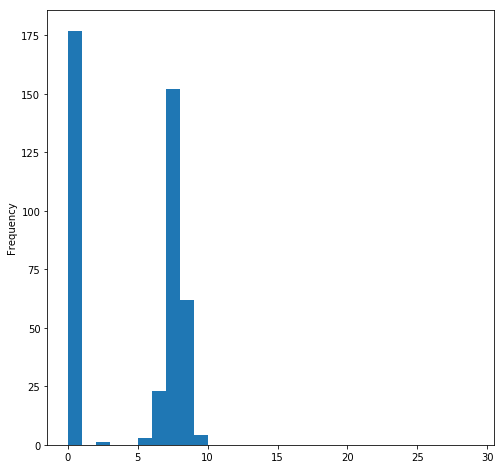

In [556]:
plt.figure(figsize=(8,8))
df = train[train.Loan_Status==1]
#df["var1"]= df["CoapplicantIncome"]/df["ApplicantIncome"]
np.log1p(df["CoapplicantIncome"]).plot(kind='hist',bins=np.arange(0,30,1))
plt.show()

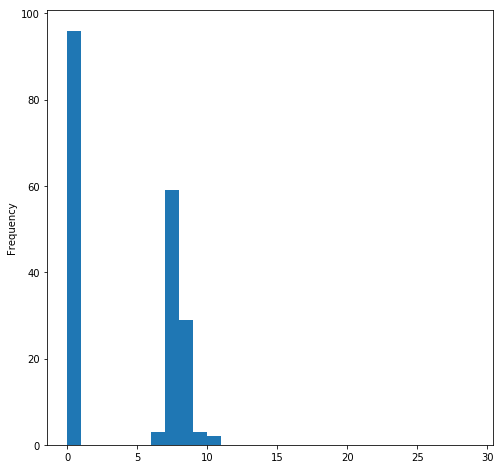

In [557]:
plt.figure(figsize=(8,8))
df = train[train.Loan_Status==0]
#df["var1"]= df["CoapplicantIncome"]/df["ApplicantIncome"]
np.log1p(df["CoapplicantIncome"]).plot(kind='hist',bins=np.arange(0,30,1))
plt.show()

In [558]:
# log_train = train.copy()
# log_test = test.copy()
# cols = ['gender', 'married','education', 'self_employed','property_area']
# for col in cols:
#     log_train[col].fillna('Missing',inplace=True)
# log_train.fillna(log_train.mean(),inplace=True)
# log_train[cols] = log_train[cols].astype(object)

# log_train[cols] = log_train[cols].apply(le.fit_transform)

# log_train['dependents'].replace("3+",4,inplace=True)
# log_train['dependents'].fillna("5",inplace=True)
# log_train['dependents'] = log_train['dependents'].astype(np.float)

# clf = LogisticRegression()
# X = log_train[[col for col in log_train.columns if col != "loan_status"]]
# y = log_train[["loan_status"]]

# #*****************************************************************************************
# # model = clf.fit(X,y)
# # pred = model.predict(X)
# # accuracy = accuracy_score(y,pred)
# # print(accuracy)
# #*****************************************************************************************


# #*****************************************************************************************
# #cross validation
# # scores = cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
# # print(scores)
# #*****************************************************************************************

# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
# cv_score = []
# pred_test =np.zeros((len(lgbm_test),1))
# for train_index,test_index in skf.split(X,y):
#     x_train,x_val = X.iloc[train_index],X.iloc[test_index]
#     y_train,y_val = y.iloc[train_index],y.iloc[test_index]
#     clf = LogisticRegression()
#     clf.fit(x_train,y_train)
#     score = round(accuracy_score(y_val,clf.predict(x_val)),4)
#     cv_score.append(score)
#     print(score,end=",")
    
#     #predictions
#     pred_test += clf.predict_proba(lgbm_test)[:,1].reshape(-1,1)


In [559]:
lgbm_train = train.copy()
lgbm_test = test.copy()

lgbm_train["traintest"]='train'
lgbm_test["traintest"]='test'
lgbm_test["Loan_Status"]=np.nan

data = pd.concat([lgbm_test,lgbm_train])

#if large data is missing
# cat_cols1 = ['Self_Employed']
# for col in cat_cols1:
#     data[col].fillna('Missing',inplace=True)

#those who dont have  credit history
cat_cols2 = ['Credit_History']
for col in cat_cols2:
    data[col].fillna(2,inplace=True)
    
#if small number of data is missing
cat_cols = ["Married",'Gender',"Dependents","Self_Employed","Loan_Amount_Term"]
for col in cat_cols:
    data[col].fillna(data[col].mode()[0],inplace=True)
    
cols = ["LoanAmount"]
for col in cols:
    data[col].fillna(data[col].median(),inplace=True)
    
    
data["Dependents"] = np.where(data["Dependents"]=='3+',3,data["Dependents"])
data["Dependents"] = data["Dependents"] .astype(int)

#data["no_applicants"] = np.where(data["CoapplicantIncome"]==0,1,2)
data["total_income"] = data["ApplicantIncome"]+data["CoapplicantIncome"]

data["loanbyincome"] = np.where(~data["ApplicantIncome"].isna(),data["LoanAmount"]/data["ApplicantIncome"],np.nan)
data["loanbytotalincome"] = np.where(~data["total_income"].isna(),data["total_income"]/data["ApplicantIncome"],np.nan)
data["loanbyterm"] =  1000*data["LoanAmount"]/data["Loan_Amount_Term"]

data["total_income_by_dependents"] = np.where(data['Dependents']==0,data["total_income"],data["total_income"]/(data["Dependents"]+1))
data["savings"] = data["total_income"]-data["loanbyterm"]


# data["ApplicantIncome"]  = np.log1p(data["ApplicantIncome"])
# data["CoapplicantIncome"]  = np.log1p(data["CoapplicantIncome"])
# data["total_income"] = np.log1p(data["total_income"])

data["Loan_Amount_Term"] = data["Loan_Amount_Term"]/12
bins_ =[0,29,39,100]
data["Loan_Amount_Term"] = pd.cut(data["Loan_Amount_Term"],bins=bins_,labels=["short","medium","high"])
data["Loan_Amount_Term"].fillna("high",inplace=True)


cols = ["ApplicantIncome","CoapplicantIncome","savings","total_income","loanbyincome","loanbytotalincome","loanbyterm"]
for col in cols:
    q1 = data[col].quantile(0.25)
    q2 = data[col].quantile(0.75)
    iqr  = q2-q1
    data[col] = np.where(data[col]>(1.5*iqr+q2),1.5*iqr+q2,data[col])
    data[col] = np.where(data[col]<(q1-1.5*iqr),q1-1.5*iqr,data[col])



cat_cols = ['Self_Employed','Credit_History',"Married",'Gender',"Dependents",'Education','Property_Area',"Loan_Amount_Term"]
data[cat_cols] = data[cat_cols].astype(object)
data[cat_cols] = data[cat_cols].apply(le.fit_transform)

#normalize data
# min_max_scaler = preprocessing.MinMaxScaler()
# cols_scale = ["ApplicantIncome","CoapplicantIncome","LoanAmount","loanbyincome","loanbyterm"]
# data[cols_scale] = data[cols_scale].apply(lambda x: (x-x.min())/(x.max()-x.min()))


lgbm_train = data[data["traintest"]=="train"]
lgbm_train.drop(["traintest"],axis=1,inplace=True)
lgbm_test = data[data["traintest"]=="test"]
lgbm_test.drop(["traintest","Loan_Status"],axis=1,inplace=True)

In [ ]:
*&^(^&(*&*))

In [398]:
# cat_cols = ['Self_Employed','Credit_History',"Married",'Gender',"Dependents",'Education',"Property_Area","Loan_Amount_Term"]
# cat_cols = [X.columns.get_loc(c) for c in cat_cols]
# lgb = LGBMClassifier(boosting_type='gbdt', 
#                       objective='binary',
#                       num_iteration=1000,
#                       num_leaves=5,
#                       min_data_in_leaf=3,
#                       max_depth=3,
#                       learning_rate=0.1,
#                       categorical_feature = cat_cols
#                      )

# params = { 'num_leaves':[3,4],
#         'min_data_in_leaf':[2,3,4],
#         'max_depth':[2,3],
#         'learning_rate':[0.02,0.01,0.03]
#        }

# grid = GridSearchCV(estimator=lgb,cv=5,param_grid=params,scoring='accuracy')
# grid.fit(X,y)
# grid.best_params_

In [645]:
X = lgbm_train.drop(["Loan_Status"],axis=1)
y = lgbm_train['Loan_Status']
test = lgbm_test.copy()


cat_cols = ['Credit_History',"Property_Area","Education","Loan_Amount_Term","Dependents","Self_Employed","Married"]
cat_cols = [X.columns.get_loc(c) for c in cat_cols]

lgb = LGBMClassifier(boosting_type='gbdt', 
                      objective='binary',
                      num_iteration=2000,
                     
                      
                      
                      max_depth=3,
                      num_leaves=4,
                      min_data_in_leaf=4,
                     
                      learning_rate=0.01,
                      categorical_feature = cat_cols,
                     random_state=101
                     )

skf = StratifiedKFold(n_splits=10,shuffle=True)
cv_score = []
pred_test =np.zeros((len(test),1))
feature_imp = np.zeros((len(X.columns),1))

for train_index,test_index in skf.split(X,y):
    x_train,x_val = X.iloc[train_index],X.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    clf = lgb
    clf.fit(x_train,y_train)
    score = round(accuracy_score(y_val,clf.predict(x_val)),3)
    cv_score.append(score)
    print(score,end=",")
    
    #predictions
    pred_test += clf.predict_proba(test)[:,1].reshape(-1,1)
    
    feature_imp += clf.feature_importances_.reshape(-1,1)
    
    
pred_test = pred_test/10
feature_imp = feature_imp/10
feature_imp = pd.DataFrame(sorted(zip(feature_imp,X.columns)), columns=['Value','Feature'])
print("\n meanscore ->",np.mean(cv_score))

0.794,0.841,0.82,0.754,0.705,0.787,0.77,0.803,0.82,0.836,
 meanscore -> 0.7929999999999999


In [646]:
X = lgbm_train.drop(["Loan_Status"],axis=1)
y = lgbm_train['Loan_Status']
test = lgbm_test.copy()

drop_cols = feature_imp.Feature.tolist()[:2]
X.drop(drop_cols,axis=1,inplace=True)
test.drop(drop_cols,axis=1,inplace=True)

cat_cols = ['Credit_History',"Property_Area","Education","Loan_Amount_Term","Dependents","Self_Employed","Married"]
cat_cols = list(set(cat_cols)-set(drop_cols))
cat_cols = [X.columns.get_loc(c) for c in cat_cols]

lgb = LGBMClassifier(boosting_type='gbdt', 
                      objective='binary',
                      num_iteration=2000,
                     
                      
                      
                      max_depth=3,
                      num_leaves=4,
                      min_data_in_leaf=4,
                     
                      learning_rate=0.01,
                      categorical_feature = cat_cols,
                     random_state=101
                     )

skf = StratifiedKFold(n_splits=10,shuffle=True)
cv_score = []
pred_test =np.zeros((len(test),1))
feature_imp = np.zeros((len(X.columns),1))

for train_index,test_index in skf.split(X,y):
    x_train,x_val = X.iloc[train_index],X.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    clf = lgb
    clf.fit(x_train,y_train)
    score = round(accuracy_score(y_val,clf.predict(x_val)),3)
    cv_score.append(score)
    print(score,end=",")
    
    #predictions
    pred_test += clf.predict_proba(test)[:,1].reshape(-1,1)
    
    feature_imp += clf.feature_importances_.reshape(-1,1)
    
    
pred_test = pred_test/10
feature_imp = feature_imp/10
feature_imp = pd.DataFrame(sorted(zip(feature_imp,X.columns)), columns=['Value','Feature'])
print("\n meanscore -",np.mean(cv_score))

0.778,0.857,0.738,0.77,0.754,0.836,0.787,0.803,0.77,0.852,
 meanscore - 0.7945


In [643]:
submission = test.copy()
submission["Loan_Status"] = pred_test
submission = submission[["Loan_Status"]]
submission["Loan_Status"] = np.where(submission["Loan_Status"]>=0.5,"Y","N")
submission.to_csv("try16.csv")

In [639]:
submission.head()

,Loan_Status
Loan_ID,
LP001015,Y
LP001022,Y
LP001031,Y
LP001035,Y
LP001051,Y


In [542]:
# parameters = {'min_samples_leaf': 3,
#               'n_estimators': 1000,
#               'min_samples_split': 10,
#               'max_features': 'sqrt',
#               'max_depth': 6}

# clf = RandomForestClassifier(**parameters)

# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
# cv_score = []
# pred_test =np.zeros((len(lgbm_test),1))

# for train_index,test_index in skf.split(X,y):
#     x_train,x_val = X.iloc[train_index],X.iloc[test_index]
#     y_train,y_val = y.iloc[train_index],y.iloc[test_index]
#     clf = lgb
#     clf.fit(x_train,y_train)
#     score = round(accuracy_score(y_val,clf.predict(x_val)),3)
#     cv_score.append(score)
#     print(score,end=",")
    
#     #predictions
#     pred_test += clf.predict_proba(lgbm_test)[:,1].reshape(-1,1)
# pred_test = pred_test/10